In [1]:
main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/"

main_path_R="/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/R_analyses/"

In [13]:
import pickle
from distutils.dir_util import copy_tree
with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/extra_scripts/src.py') as f:
    exec(f.read())
torch.manual_seed(1)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set(style="whitegrid")
#from lifelines import CoxPHFitter
#from captum.attr import DeepLiftShap

In [14]:
min_optuna=10
hyperparam_epochs=200 #max per trial(note that we add burn in inside the loop
hyperparam_trials=100 #number of trials for each model.
patience=5
burn_in=10
num_epochs=1000
k=100
bsize=2048
zi=False
validation_ratio=0.2 #10% of dataset is kept for validation during training. we do not use a testing set since we're only interested in what it learned not generalizability.


main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/"
dataLocation="/home/jislam/Documents/gits/scRNAseq_datasets/hpap_batch_corrected.final3k.h5ad"
filter_by="cell_type"
categories_to_keep = 8 #number of cell types I want to keep in the model sorted by decreasing cell count, can use all but only so much weighted losses can do...
category_labels=["cell_disease"] # See adata.obs.columns for what categories you can use here. Specify which columns to one-hot-encode and use to inform the models. cell_disease is generated for the interaction.

group_a=["beta_cell_T2D"]
group_b=["beta_cell_Control"]
shared_filter =None

single_cell_data="hpapnb3k"



outdir=single_cell_data.replace(" ", "_")
if not os.path.exists(outdir):
    os.makedirs(outdir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adata=sc.read_h5ad(dataLocation)
adata.obs['cell_type']=adata.obs['cell_type'].str.replace(" ", "_", regex=False)
adata=adata[adata.obs["disease_state"]!="AAB"]
adata=adata[adata.obs["disease_state"]!="T1D"]
adata=adata[adata.obs["cell_type"]!="unknown"]
adata= adata[adata.obs['cell_type'].isin(['alpha_cell', 'delta_cell', 'beta_cell', 'PP_cell','acinar_cell'])]#, 'precursor_alpha_beta_cell'
#adata.obs.loc[adata.obs['cell_type']=='precursor_alpha_beta_cell','cell_type']="precursor_cell"

adata.obs["cell_disease"]=adata.obs["cell_type"].astype(str) + '_' + adata.obs["disease_state"].astype(str)

one_hot_labels, num_categories= gosip.one_hot_encode_combinations(adata.obs, category_labels)
adata.one_hot_labels= one_hot_labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adata.obs['cell_disease'].unique()
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib import patheffects as pe

def plot_cell_umap_and_distributions(adata, output_file="hpap.pdf"):
    """
    3‐panel figure:
      A) UMAP colored by cell_type×disease_state (10 colors; no legend)
      B) Control barplot, C) T2D barplot,
    with counts placed inside bars ≥20% of max, else outside, all in black
    with white outline.
    """
    # 1) Publication styling
    sns.set_context("paper", font_scale=1.2)
    rcParams.update({
        "font.size":       12,
        "axes.titlesize":  12,
        "axes.labelsize":  12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi":     300,
    })
    
    # 2) Cell‐types, pretty names, 10‐color palette
    cell_types = ["alpha_cell","beta_cell","acinar_cell","delta_cell","PP_cell"]
    pretty = {
        "alpha_cell":"Alpha cell",
        "beta_cell": "Beta cell",
        "acinar_cell":"Acinar cell",
        "delta_cell":"Delta cell",
        "PP_cell":   "PP cell"
    }
    combos = [f"{ct}_Control" for ct in cell_types] + [f"{ct}_T2D" for ct in cell_types]
    combo_palette = dict(zip(combos, sns.color_palette("tab10", n_colors=len(combos))))

    
    # 2’) Define a colorblind‐safe paired palette
    base_colors = {
        "alpha_cell": "#fb9a99",
        "beta_cell":  "#b2df8a",
        "acinar_cell":"#a6cee3",
        "delta_cell": "#fdbf6f",
        "PP_cell":    "#cab2d6",
    }
    dark_colors = {
        "alpha_cell": "#e31a1c",
        "beta_cell":  "#33a02c",
        "acinar_cell":"#1f78b4",
        "delta_cell": "#ff7f00",
        "PP_cell":    "#6a3d9a",
    }
    
    # build the 10‐category palette
    combo_palette = {}
    for ct in cell_types:
        combo_palette[f"{ct}_Control"] = base_colors[ct]
        combo_palette[f"{ct}_T2D"]     = dark_colors[ct]
    
    # 3) Figure & gridspec
    fig = plt.figure(figsize=(6.5, 6.5))
    gs  = fig.add_gridspec(2, 2, height_ratios=[1, 0.8])
    
    # — Panel A: UMAP —
    ax0 = fig.add_subplot(gs[0, :])
    sc.pl.umap(
        adata,
        color="cell_disease",
        palette=combo_palette,
        ax=ax0,
        show=False,
        s=5, alpha=0.8
    )
    ax0.set_title("UMAP of cells by cell type & disease")
    if ax0.get_legend(): 
        ax0.legend_.remove()
    
    # — Panels B & C: barplots —
    for col, state in enumerate(["Control", "T2D"]):
        ax = fig.add_subplot(gs[1, col])
        sub    = adata.obs.query("disease_state == @state")
        counts = sub["cell_type"].value_counts().reindex(cell_types)
        
        # draw bars
        colors = [combo_palette[f"{ct}_{state}"] for ct in counts.index]
        sns.barplot(
            x=counts.values,
            y=[pretty[ct] for ct in counts.index],
            palette=colors,
            ax=ax
        )
        
        # two‐line title
        ax.set_title(f"{state} state:\nCell type distribution", loc="center")
        ax.set_xlabel("Cell count")
        ax.set_ylabel("")
        
        # 5% white margin on the right
        maxc = counts.max()
        ax.set_xlim(0, maxc * 1.05)
        
        # annotate: inside if ≥20% of max, else outside
        threshold = maxc * 0.20
        offset    = maxc * 0.02
        
        for x, y in zip(counts.values, range(len(counts))):
            if x >= threshold:
                # inside
                xpos, ha = x - offset, "right"
            else:
                # outside
                xpos, ha = x + offset, "left"
            
            txt = ax.text(
                xpos, y, str(x),
                va="center", ha=ha,
                color="black", fontsize=10,
                clip_on=False
            )
            # white outline
            txt.set_path_effects([
                pe.Stroke(linewidth=2, foreground="white"),
                pe.Normal()
            ])
    
    # 4) Adjust spacing
    fig.subplots_adjust(
        left=0.08, right=0.98,
        top=0.94,  bottom=0.08,
        wspace=0.4, hspace=0.3
    )
    
    # 5) Panel letters
    fig.text(0.02, 0.96, "A", fontsize=14, fontweight="bold")
    fig.text(0.02, 0.46, "B", fontsize=14, fontweight="bold")
    fig.text(0.52, 0.46, "C", fontsize=14, fontweight="bold")
    
    # 6) Save
    plt.tight_layout()
    fig.savefig(output_file)

    plt.show()
    plt.close(fig)


plot_cell_umap_and_distributions(adata, output_file=f'{main_path}{single_cell_data}/hpapnb-batch_corrected.png')
#fig.savefig()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/jislam/Documents/gits/scRNAseq_datasets/hpap_batch_corrected.final3k.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


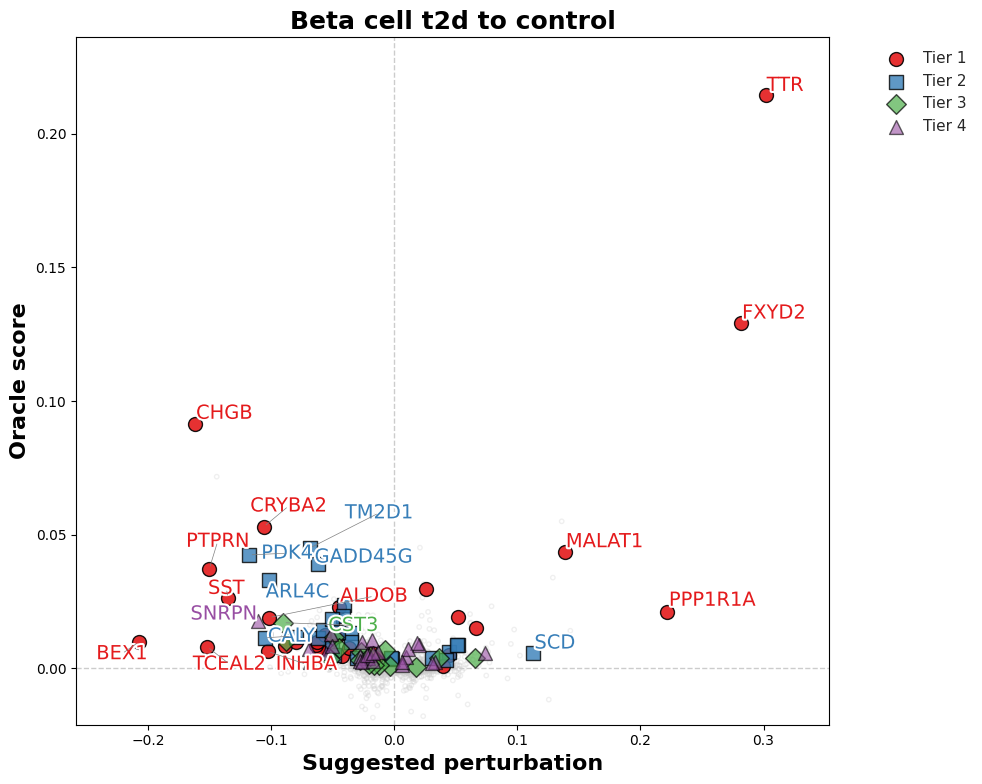

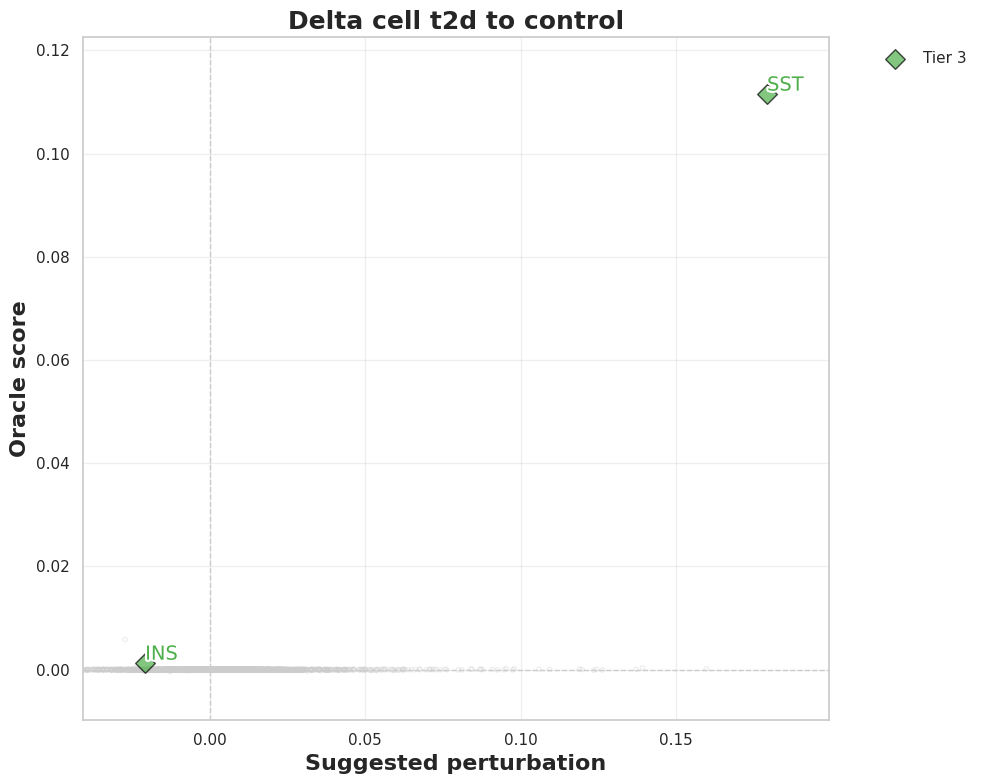

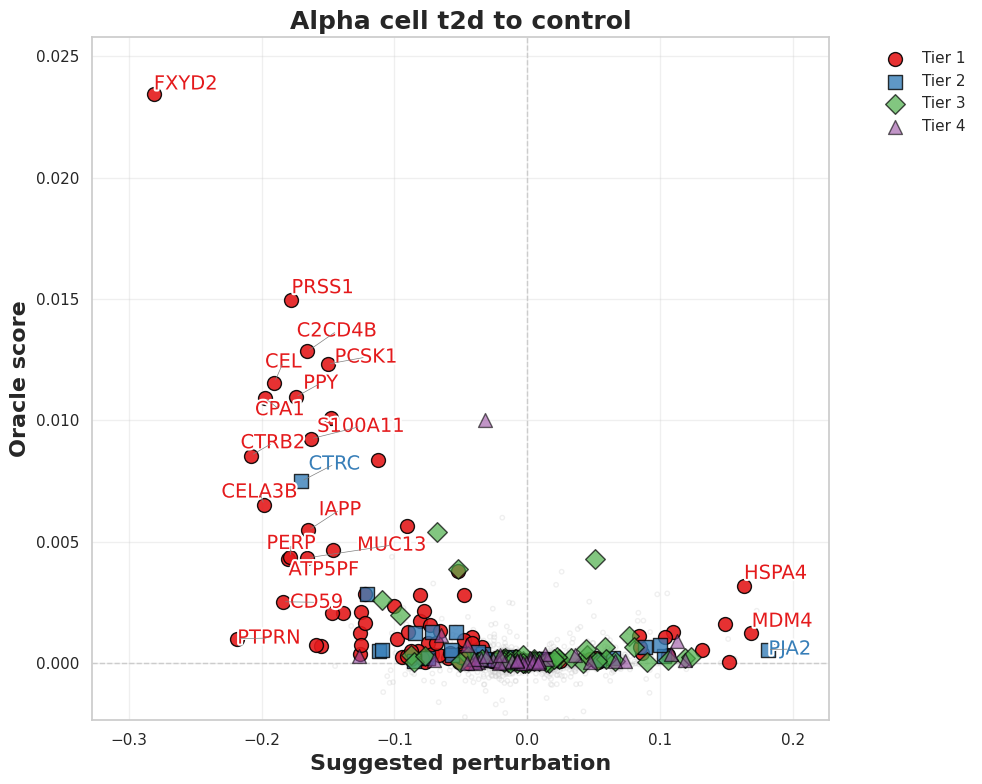

In [2]:

import os
import xlsxwriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from adjustText import adjust_text
import matplotlib.patheffects as patheffects
import os
from adjustText import adjust_text

def plot_gene_categorization(
    results: pd.DataFrame,
    a2b_subtitle: str,
    priority_col: str,
    figsize: tuple = (10, 8),
    top_n: int = 20,
    ax=None,
    font_size: int = 14
) -> plt.Axes:
    """
    Scatterplot of A->B perturbation vs. oracle_score, colored by enhanced palette and improved annotations.
    Drop-in replacement that uses a seaborn color palette with distinct markers per tier,
    and refined annotation spacing via adjust_text parameters.
    Returns a Matplotlib Axes object.
    """
    df = results.copy()
    x = f'pert_{a2b_subtitle}'
    y = f'oracle_score_{a2b_subtitle}'

    # Compute annotation priority: sum of absolute shifts
    df['_label_score'] = df[x].abs() + df[y].abs()
    high_priority = df[df[priority_col].isin([1,2,3,4])]
    annotate_df = high_priority.nlargest(top_n, '_label_score')

    tiers_1to4_df = df[df[priority_col].isin([1, 2, 3, 4])]
    use_custom_lims = not tiers_1to4_df.empty
    
    if use_custom_lims:
        x_min, x_max = tiers_1to4_df[x].min(), tiers_1to4_df[x].max()
        y_min, y_max = tiers_1to4_df[y].min(), tiers_1to4_df[y].max()
        x_pad = (x_max - x_min) * 0.1 if x_max != x_min else 1
        y_pad = (y_max - y_min) * 0.1 if y_max != y_min else 1
        xlim = (x_min - x_pad, x_max + x_pad)
        ylim = (y_min - y_pad, y_max + y_pad)
    # Compute annotation priority: sum of absolute shifts
    df['_label_score'] = df[x].abs() + df[y].abs()
    high_priority = df[df[priority_col].isin([1,2,3,4])]
    annotate_df = high_priority.nlargest(top_n, '_label_score')

    # Setup plot
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.set(style='whitegrid', rc={'grid.alpha': 0.3})

    # Enhanced color palette and markers
    palette = sns.color_palette("Set1", 4)
    fixed_colors = {tier: palette[tier-1] for tier in [1,2,3,4]}
    fixed_colors[5] = '#cccccc'
    fixed_markers = {1: 'o', 2: 's', 3: 'D', 4: '^', 5: 'o'}
    fixed_sizes = {tier: 100 for tier in [1,2,3,4]}
    fixed_sizes[5] = 10

    # Plot tier 5 (low priority) first
    low_df = df[df[priority_col] == 5]
    if not low_df.empty:
        ax.scatter(
            low_df[x], low_df[y],
            facecolors='none',
            edgecolors=fixed_colors[5],
            marker=fixed_markers[5],
            s=fixed_sizes[5],
            alpha=0.3,
            zorder=1,
            label=None
        )

    # Plot tiers 1–4
    for tier in [1, 2, 3, 4]:
        sub = df[df[priority_col] == tier]
        if sub.empty:
            continue
        ax.scatter(
            sub[x], sub[y],
            label=f'Tier {tier}',
            color=fixed_colors[tier],
            marker=fixed_markers[tier],
            s=fixed_sizes[tier],
            edgecolor='black',
            alpha={1:0.9, 2:0.8, 3:0.7, 4:0.6}[tier],
            zorder=2
        )



    # Reference lines
    ax.axhline(0, color='gray', linestyle='--', lw=1, alpha=0.4, zorder=0)
    ax.axvline(0, color='gray', linestyle='--', lw=1, alpha=0.4, zorder=0)

    # Labels and title
    ax.set_xlabel('Suggested perturbation', fontsize=font_size+2, fontweight='bold')
    ax.set_ylabel('Oracle score', fontsize=font_size+2, fontweight='bold')
    ax.set_title(a2b_subtitle.replace('_', ' '), fontsize=font_size+4, fontweight='bold')

    # Legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    if use_custom_lims:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    # Annotate top genes (tiers 1–4)
    texts = []
    for _, row in annotate_df.iterrows():
        texts.append(
            ax.text(
                row[x], row[y], row.name,
                fontsize=font_size,# weight='bold',
                color=fixed_colors[row[priority_col]],
                path_effects=[patheffects.withStroke(linewidth=3, foreground='white')],
                clip_on=True  # <-- This ensures the text stays within axes
            )
        )
    adjust_text(
        texts, ax=ax,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        force_text=0.5,
        force_points=0.3,
        expand_points=(1.2, 1.2)
    )
    plt.tight_layout()
    return ax

import os
import pandas as pd

def complete_analysis_pipeline(
    results_path: str,
    a2b_subpath: str,
    b2a_subpath: str,
    a2b_subtitle: str,
    b2a_subtitle: str,
    main_title: str,
    main_path: str,
    oracle_score: str = "oracle_score",
    oracle_score_pval_col: str = "oracle_score_pval_acat_fdr",
    suggested_perturbation: str = "suggested_perturbation",
    out_degree_pagerank: str = "out_degree_pagerank_positive",
    in_degree_pagerank: str = "in_degree_pagerank_positive",
    label: str = 'label',
    fdr_threshold: float = 0.1,
    pagerank_quantile: float = 0.75
) -> dict:
    """
    Perform forward-centric classification of gene perturbations,
    returning:
      - a2b_results: A->B sorted raw results,
      - b2a_results: B->A sorted raw results,
      - integrated: classification DataFrame with categories & priorities,
      - description tables for each category mapping codes to full text.
    """
    # Load input
    a2b_data = pd.read_csv(os.path.join(results_path, a2b_subpath), index_col=0)
    b2a_data = pd.read_csv(os.path.join(results_path, b2a_subpath), index_col=0)

    # Validate
    required = [label, oracle_score, oracle_score_pval_col,
                suggested_perturbation, out_degree_pagerank, in_degree_pagerank]
    for df,name in zip([a2b_data,b2a_data],["forward","reverse"]):
        missing = set(required)-set(df.columns)
        if missing:
            raise ValueError(f"Missing columns in {name}: {missing}")

    # Raw sorted results
    a2b_results = a2b_data.sort_values(oracle_score, ascending=False)
    b2a_results = b2a_data.sort_values(oracle_score, ascending=False)

    # Subset
    a2b = a2b_data[required].copy()
    b2a = b2a_data[required].copy()
    res = pd.DataFrame(index=a2b.index)

    # Copy metrics
    res[f"oracle_score_{a2b_subtitle}"] = a2b[oracle_score]
    res[f"oracle_score_{b2a_subtitle}"] = b2a[oracle_score]
    res[f"pval_acat_fdr_{a2b_subtitle}"] = a2b[oracle_score_pval_col]
    res[f"pval_acat_fdr_{b2a_subtitle}"] = b2a[oracle_score_pval_col]
    res[f"pert_{a2b_subtitle}"] = a2b[suggested_perturbation]
    res[f"pert_{b2a_subtitle}"] = b2a[suggested_perturbation]
    res[f"out_pr_{a2b_subtitle}"] = a2b[out_degree_pagerank]
    res[f"out_pr_{b2a_subtitle}"] = b2a[out_degree_pagerank]
    res[f"in_pr_{a2b_subtitle}"] = a2b[in_degree_pagerank]
    res[f"in_pr_{b2a_subtitle}"] = b2a[in_degree_pagerank]

    # Masks
    sig_fwd = res[f"pval_acat_fdr_{a2b_subtitle}"] < fdr_threshold
    sig_rev = res[f"pval_acat_fdr_{b2a_subtitle}"] < fdr_threshold
    sc_fwd = res[f"oracle_score_{a2b_subtitle}"]
    sc_rev = res[f"oracle_score_{b2a_subtitle}"]
    sp_fwd = res[f"pert_{a2b_subtitle}"]
    sp_rev = res[f"pert_{b2a_subtitle}"]

    # Pagerank thresholds
    q_out_fwd = res[f"out_pr_{a2b_subtitle}"].quantile(pagerank_quantile)
    q_out_rev = res[f"out_pr_{b2a_subtitle}"].quantile(pagerank_quantile)
    q_in_fwd  = res[f"in_pr_{a2b_subtitle}"].quantile(pagerank_quantile)
    q_in_rev  = res[f"in_pr_{b2a_subtitle}"].quantile(pagerank_quantile)

    # Categories
    def pv_cat(i):
        if sig_fwd[i] and sig_rev[i]: return "bidirectional_evidence"
        if sig_fwd[i]: return "forward_only_evidence"
        if sig_rev[i]: return "reverse_only_evidence"
        return "none"
    res['p_value_category'] = [pv_cat(i) for i in res.index]

    def reg_cat(i):
        if sig_fwd[i] and sig_rev[i] and sp_fwd[i]*sp_rev[i] < 0:
            if sc_fwd[i]>0 and sc_rev[i]>0: return "bidirectional_regulator"
            if sc_fwd[i]<0 and sc_rev[i]<0: return "bidirectional_anti_regulator"
        if sig_fwd[i]: return "forward_regulator" if sc_fwd[i]>0 else "forward_anti_regulator"
        return "none"
    res['regulator_category'] = [reg_cat(i) for i in res.index]

    def drv_cat(i):
        hf = res[f"out_pr_{a2b_subtitle}"][i]>=q_out_fwd
        hr = res[f"out_pr_{b2a_subtitle}"][i]>=q_out_rev
        if hf and hr: return "bidirectional_driver"
        if hf: return "forward_driver"
        if hr: return "reverse_driver"
        return "none"
    res['driver_category'] = [drv_cat(i) for i in res.index]

    def mkr_cat(i):
        hf = res[f"in_pr_{a2b_subtitle}"][i]>=q_in_fwd
        hr = res[f"in_pr_{b2a_subtitle}"][i]>=q_in_rev
        if hf and hr: return "bidirectional_marker"
        if hf: return "forward_marker"
        if hr: return "reverse_marker"
        return "none"
    res['marker_category'] = [mkr_cat(i) for i in res.index]

    # Priority tiers numeric
    def drv_tier_forward(i):
        rc,dc = res.at[i,'regulator_category'],res.at[i,'driver_category']
        if rc=='bidirectional_regulator' and dc=='bidirectional_driver': return 1
        if rc=='bidirectional_regulator' and dc=='forward_driver': return 2
        if rc=='forward_regulator' and dc=='bidirectional_driver': return 3
        if rc=='forward_regulator' and dc=='forward_driver': return 4
        return 5
    res['driver_tier_forward'] = [drv_tier_forward(i) for i in res.index]

    def drv_tier_anti(i):
        rc,dc = res.at[i,'regulator_category'],res.at[i,'driver_category']
        if rc=='bidirectional_anti_regulator' and dc=='bidirectional_driver': return 1
        if rc=='bidirectional_anti_regulator' and dc=='forward_driver': return 2
        if rc=='forward_anti_regulator' and dc=='bidirectional_driver': return 3
        if rc=='forward_anti_regulator' and dc=='forward_driver': return 4
        return 5
    res['driver_tier_anti'] = [drv_tier_anti(i) for i in res.index]

    def mkr_tier_forward(i):
        rc,mc = res.at[i,'regulator_category'],res.at[i,'marker_category']
        if rc=='bidirectional_regulator' and mc=='bidirectional_marker': return 1
        if rc=='bidirectional_regulator' and mc=='forward_marker': return 2
        if rc=='forward_regulator' and mc=='bidirectional_marker': return 3
        if rc=='forward_regulator' and mc=='forward_marker': return 4
        return 5
    res['marker_tier_forward'] = [mkr_tier_forward(i) for i in res.index]

    def mkr_tier_anti(i):
        rc,mc = res.at[i,'regulator_category'],res.at[i,'marker_category']
        if rc=='bidirectional_anti_regulator' and mc=='bidirectional_marker': return 1
        if rc=='bidirectional_anti_regulator' and mc=='forward_marker': return 2
        if rc=='forward_anti_regulator' and mc=='bidirectional_marker': return 3
        if rc=='forward_anti_regulator' and mc=='forward_marker': return 4
        return 5
    res['marker_tier_anti'] = [mkr_tier_anti(i) for i in res.index]

        # Descriptive mappings with full filter criteria
        # Descriptive mappings with full filter criteria (spelled out)
    pval_map = {
        'bidirectional_evidence': 'A->B p-value < alpha AND B->A p-value < alpha',
        'forward_only_evidence': 'A->B p-value < alpha AND B->A p-value >= alpha',
        'reverse_only_evidence': 'B->A p-value < alpha AND A->B p-value >= alpha',
        'none': 'A->B p-value >= alpha AND B->A p-value >= alpha'
    }
    reg_map = {
        'bidirectional_regulator': (
            'A->B and B->A p-value < alpha; suggested perturbations opposite sign; '
            'oracle score > 0 in both directions'
        ),
        'bidirectional_anti_regulator': (
            'A->B and B->A p-value < alpha; suggested perturbations opposite sign; '
            'oracle score < 0 in both directions'
        ),
        'forward_regulator': 'A->B p-value < alpha AND oracle score > 0',
        'forward_anti_regulator': 'A->B p-value < alpha AND oracle score < 0',
        'none': 'No forward significance or regulator properties'
    }
    tier_forward_map = {
        1: 'A->B and B->A p-value < alpha; flip-sign perturbations; oracle score > 0 both; out-degree high both',
        2: 'A->B and B->A p-value < alpha; flip-sign perturbations; oracle score > 0 both; out-degree high A->B only',
        3: 'A->B p-value < alpha; oracle score > 0; out-degree high both',
        4: 'A->B p-value < alpha; oracle score > 0; out-degree high A->B only',
        5: 'Low priority'
    }
    tier_anti_map = {
        1: 'A->B and B->A p-value < alpha; flip-sign perturbations; oracle score < 0 both; out-degree high both',
        2: 'A->B and B->A p-value < alpha; flip-sign perturbations; oracle score < 0 both; out-degree high A->B only',
        3: 'A->B p-value < alpha; oracle score < 0; out-degree high both',
        4: 'A->B p-value < alpha; oracle score < 0; out-degree high A->B only',
        5: 'Low priority'
    }
    marker_forward_map = {
        1: 'A->B and B->A p-value < alpha; flip-sign perturbations; oracle score > 0 both; in-degree high both',
        2: 'A->B and B->A p-value < alpha; flip-sign perturbations; oracle score > 0 both; in-degree high A->B only',
        3: 'A->B p-value < alpha; oracle score > 0; in-degree high both',
        4: 'A->B p-value < alpha; oracle score > 0; in-degree high A->B only',
        5: 'Low priority'
    }
    marker_anti_map = {
        1: 'A->B and B->A p-value < alpha; flip-sign perturbations; oracle score < 0 both; in-degree high both',
        2: 'A->B and B->A p-value < alpha; flip-sign perturbations; oracle score < 0 both; in-degree high A->B only',
        3: 'A->B p-value < alpha; oracle score < 0; in-degree high both',
        4: 'A->B p-value < alpha; oracle score < 0; in-degree high A->B only',
        5: 'Low priority'
    }

    # Category description tables
    pval_description = pd.DataFrame(
        list(pval_map.items()), columns=['p_value_category','description']
    )
    regulator_description = pd.DataFrame(
        list(reg_map.items()), columns=['regulator_category','description']
    )
    driver_forward_description = pd.DataFrame(
        list(tier_forward_map.items()), columns=['driver_tier_forward','description']
    )
    driver_anti_description = pd.DataFrame(
        list(tier_anti_map.items()), columns=['driver_tier_anti','description']
    )
    marker_forward_description = pd.DataFrame(
        list(tier_forward_map.items()), columns=['marker_tier_forward','description']
    )
    marker_anti_description = pd.DataFrame(
        list(tier_anti_map.items()), columns=['marker_tier_anti','description']
    )

    # Plot primary driver-forward tiers
    plot_gene_categorization(
        res,
        a2b_subtitle=a2b_subtitle,
        priority_col='driver_tier_forward'
    )

    
    to_return= {
        a2b_subtitle: a2b_data.sort_values(oracle_score,ascending=False),
        b2a_subtitle: b2a_data.sort_values(oracle_score,ascending=False),
        'gene_categorization_results': res,
        'p_value_description': pval_description,
        'regulator_description': regulator_description,
        'driver_forward_description': driver_forward_description,
        'driver_anti_description': driver_anti_description,
        'marker_forward_description': marker_forward_description,
        'marker_anti_description': marker_anti_description
    }


    


    # Define the output file path
    output_excel_path = os.path.join(results_path, f"{main_title}_analysis_results.xlsx")
    
    # Save the dictionary to an Excel file with multiple sheets
    with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
        for sheet_name, df in to_return.items():
            df.to_excel(writer, sheet_name=sheet_name)
           
    return to_return

results_path='/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/hpapnb3k/'

beta=complete_analysis_pipeline(
results_path = results_path,
a2b_subpath = 'from_beta_cell_T2D_to_beta_cell_Control/summary_statistics.csv',
b2a_subpath = 'from_beta_cell_Control_to_beta_cell_T2D/summary_statistics.csv',
a2b_subtitle = "Beta_cell_t2d_to_control",
b2a_subtitle = "Beta_cell_control_to_t2d",
main_title = "hpapnb3k_beta_t2d_to_control",
main_path=main_path
)



delta=complete_analysis_pipeline(
results_path = results_path,
a2b_subpath = 'from_delta_cell_T2D_to_delta_cell_Control/summary_statistics.csv',
b2a_subpath = 'from_delta_cell_Control_to_delta_cell_T2D/summary_statistics.csv',
a2b_subtitle = "Delta_cell_t2d_to_control",
b2a_subtitle = "Delta_cell_control_to_t2d",
main_title = "hpapnb3k_delta_t2d_to_control",
main_path=main_path
)

alpha=complete_analysis_pipeline(
results_path = results_path,
a2b_subpath = 'from_alpha_cell_T2D_to_alpha_cell_Control/summary_statistics.csv',
b2a_subpath = 'from_alpha_cell_Control_to_alpha_cell_T2D/summary_statistics.csv',
a2b_subtitle = "Alpha_cell_t2d_to_control",
b2a_subtitle = "Alpha_cell_control_to_t2d",
main_title =  "hpapnb3k_alpha_t2d_to_control",
main_path=main_path
)


In [3]:
beta['gene_categorization_results'].sort_values('driver_tier_forward').head()

,oracle_score_Beta_cell_t2d_to_control,oracle_score_Beta_cell_control_to_t2d,pval_acat_fdr_Beta_cell_t2d_to_control,pval_acat_fdr_Beta_cell_control_to_t2d,pert_Beta_cell_t2d_to_control,pert_Beta_cell_control_to_t2d,out_pr_Beta_cell_t2d_to_control,out_pr_Beta_cell_control_to_t2d,in_pr_Beta_cell_t2d_to_control,in_pr_Beta_cell_control_to_t2d,p_value_category,regulator_category,driver_category,marker_category,driver_tier_forward,driver_tier_anti,marker_tier_forward,marker_tier_anti
gene_name,,,,,,,,,,,,,,,,,,
TUNAR,0.012218,0.000072,2.379410e-09,5.363536e-09,-0.046290,0.104988,1.063929,1.689734,1.635311,1.158892,bidirectional_evidence,bidirectional_regulator,bidirectional_driver,forward_marker,1,5,2,5
TTR,0.214654,0.006020,3.074464e-13,1.024821e-13,0.302191,-0.232588,76.913187,318.977927,1.001207,1.078745,bidirectional_evidence,bidirectional_regulator,bidirectional_driver,none,1,5,5,5
SST,0.026344,0.000005,3.074464e-13,1.024821e-13,-0.135215,0.252407,56.414815,223.276764,1.043332,1.037940,bidirectional_evidence,bidirectional_regulator,bidirectional_driver,none,1,5,5,5
TCEAL2,0.007978,0.000011,4.493213e-04,1.269274e-05,-0.151836,0.241147,1.087397,15.559886,1.043051,1.338521,bidirectional_evidence,bidirectional_regulator,bidirectional_driver,none,1,5,5,5
S100A6,0.009884,0.000112,8.804997e-04,2.483889e-13,-0.062900,0.145134,1.079035,81.106951,1.108208,1.793972,bidirectional_evidence,bidirectional_regulator,bidirectional_driver,reverse_marker,1,5,5,5


In [4]:


def volcano_plot(data, log2_fc_col='log2FC', pval_col='pval', 
                 fc_threshold=1.5, pval_threshold=0.05, 
                 label_col=None, 
                 title='Volcano Plot', ax=None):
    """
    Creates a volcano plot and labels only the most significant top-left and top-right points.

    Parameters:
        data (pd.DataFrame): DataFrame containing log2 fold-change and p-values.
        log2_fc_col (str): Column name for log2 fold-change.
        pval_col (str): Column name for p-values.
        fc_threshold (float): Threshold for log2 fold-change significance.
        pval_threshold (float): Threshold for p-value significance.
        label_col (str or None): Column name for labels (e.g., gene names). If None, indexes are used.
        figsize (tuple): Figure size.
        title (str): Title of the plot.
        ax (matplotlib.axes._subplots.AxesSubplot or None): Axis object to plot on (for subplots).
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    df = data.copy()
    df['neg_log10_pval'] = -np.log10(df[pval_col].clip(lower=1e-10))  # Avoid log(0)

    # Categorize points
    df['Significance'] = 'Not Significant'
    df.loc[(df[log2_fc_col] > fc_threshold) & (df[pval_col] < pval_threshold), 'Significance'] = 'Upregulated'
    df.loc[(df[log2_fc_col] < -fc_threshold) & (df[pval_col] < pval_threshold), 'Significance'] = 'Downregulated'

    # Plot
    sns.scatterplot(data=df, x=log2_fc_col, y='neg_log10_pval', hue='Significance',
                    palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'red'},
                    alpha=0.6, edgecolor=None, ax=ax)

    # Add significance lines
    ax.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
    ax.axvline(fc_threshold, color='black', linestyle='--', linewidth=1)
    ax.axvline(-fc_threshold, color='black', linestyle='--', linewidth=1)

    # Labels and title
    ax.set_xlabel('Log2 Fold Change',fontsize=16)
    ax.set_ylabel('-Log10 P-value',fontsize=16)
    ax.set_title(title,fontsize=18)
    ax.legend(title="Significance",loc='center left', bbox_to_anchor=(1, 0.5))

    # **Label only the most significant top-left and top-right points**
    top_left = df[(df[log2_fc_col] < -fc_threshold) & (df[pval_col] < pval_threshold)].nsmallest(3, pval_col)
    top_right = df[(df[log2_fc_col] > fc_threshold) & (df[pval_col] < pval_threshold)].nsmallest(3, pval_col)

    texts = []
    for _, row in pd.concat([top_left, top_right]).iterrows():
        label = row[label_col] if label_col else f"ID: {row.name}"  # Use label column or index
        texts.append(ax.text(row[log2_fc_col], row['neg_log10_pval'], label, 
                             fontsize=16, color='red', ha='right', va='bottom'))

    # **Adjust labels to prevent overlap**
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=1), ax=ax)


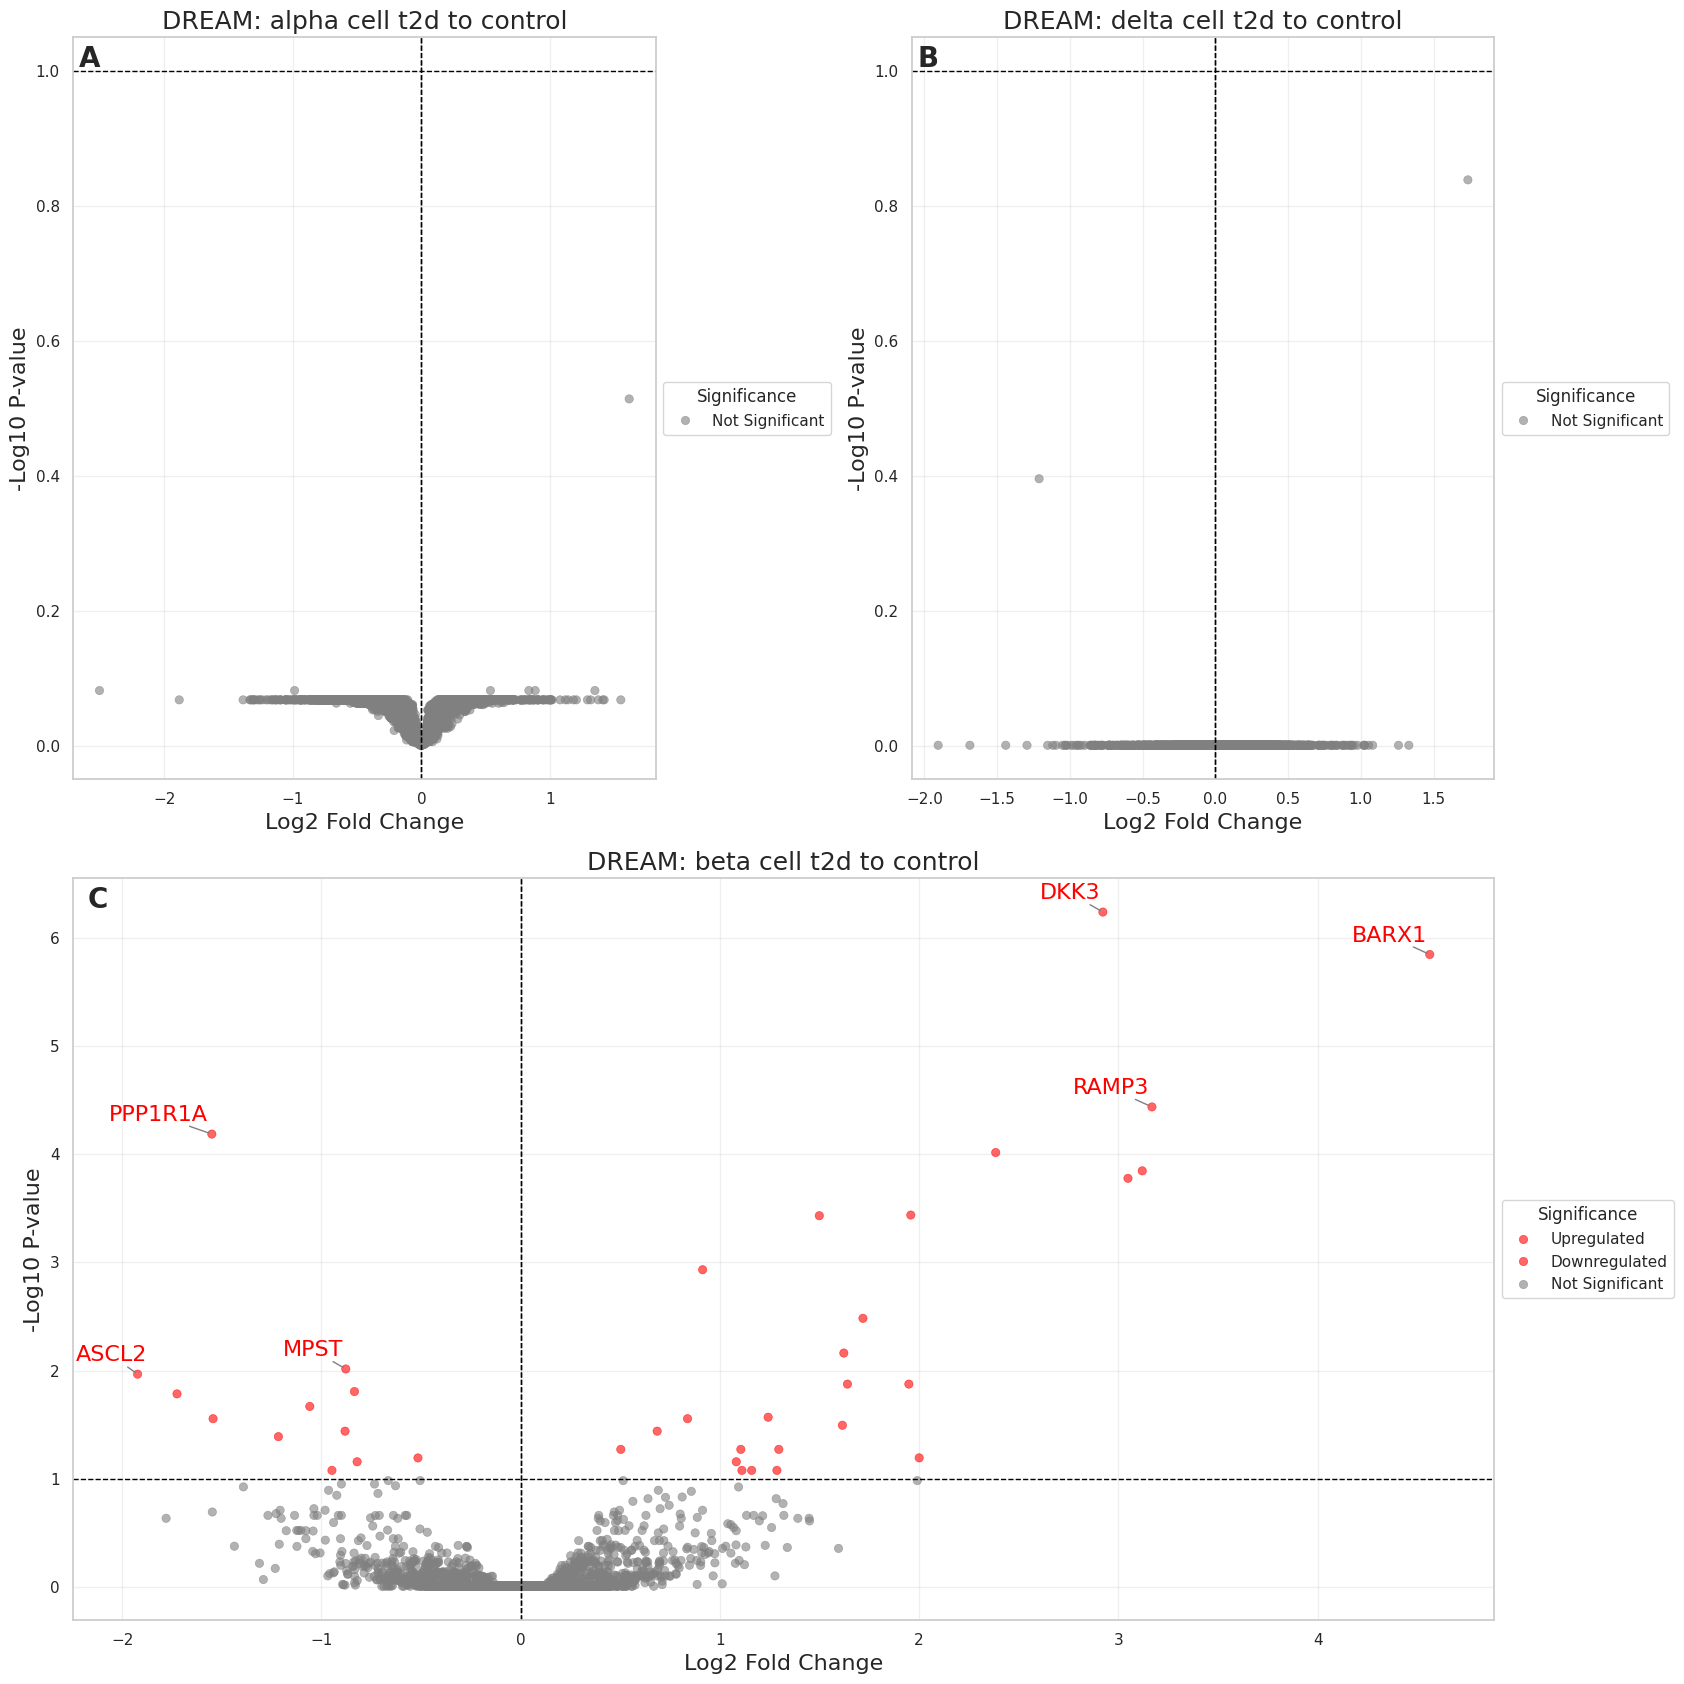

In [6]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

t2doverctrlalpha=pd.read_csv(f'{main_path_R}t2doverctrlalpha.csv')
t2doverctrlbeta=pd.read_csv(f'{main_path_R}t2doverctrlbeta.csv')
t2doverctrldelta=pd.read_csv(f'{main_path_R}t2doverctrldelta.csv')
# Create the grid layout
base_width = 17
base_height = 17 
fig = plt.figure(figsize=(base_width, base_height))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Axes
ax_alpha = fig.add_subplot(gs[0, 0])  # A
ax_delta = fig.add_subplot(gs[0, 1])  # B
ax_beta  = fig.add_subplot(gs[1, :])  # C
lab_col="gene_name" #gene_name later
# Plot panels
volcano_plot(t2doverctrlalpha, log2_fc_col='logFC', pval_col='adj.P.Val', 
                 fc_threshold=0, pval_threshold=0.1, 
                  label_col=lab_col, title='DREAM: alpha cell t2d to control',ax=ax_alpha)
volcano_plot(t2doverctrldelta, log2_fc_col='logFC', pval_col='adj.P.Val', 
                 fc_threshold=0, pval_threshold=0.1, 
                 label_col=lab_col, title='DREAM: delta cell t2d to control',ax=ax_delta)
volcano_plot(t2doverctrlbeta, log2_fc_col='logFC', pval_col='adj.P.Val', 
                 fc_threshold=0, pval_threshold=0.1, 
                 label_col=lab_col, title='DREAM: beta cell t2d to control',ax=ax_beta)

# Add panel labels (top-left of each axis)
for label, ax in zip(['A', 'B', 'C'], [ax_alpha, ax_delta, ax_beta]):
    ax.text(
        0.01, 0.99, label,
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=20,
        fontweight='bold'
    )

# Clean layout
plt.tight_layout()
plt.show()
fig.savefig("DREAM_gene_categorization_panel_SUPPLEMENTAL.png", dpi=500, bbox_inches='tight')

In [7]:

dreamcopy_beta=beta['gene_categorization_results'].copy()

dreamcopy_beta['dream_hit'] = dreamcopy_beta.index.isin(t2doverctrlbeta[t2doverctrlbeta['adj.P.Val']<0.1]['gene_name'])
#has 51 hits with an FDR adj. pvalue < 0.05
dream_counts = dreamcopy_beta.groupby('driver_tier_forward')['dream_hit'].sum().reset_index()



In [8]:
dream_counts

,driver_tier_forward,dream_hit
0,1,6
1,2,0
2,3,0
3,4,0
4,5,31


In [9]:
dream_counts['dream_hit'].sum()

np.int64(37)

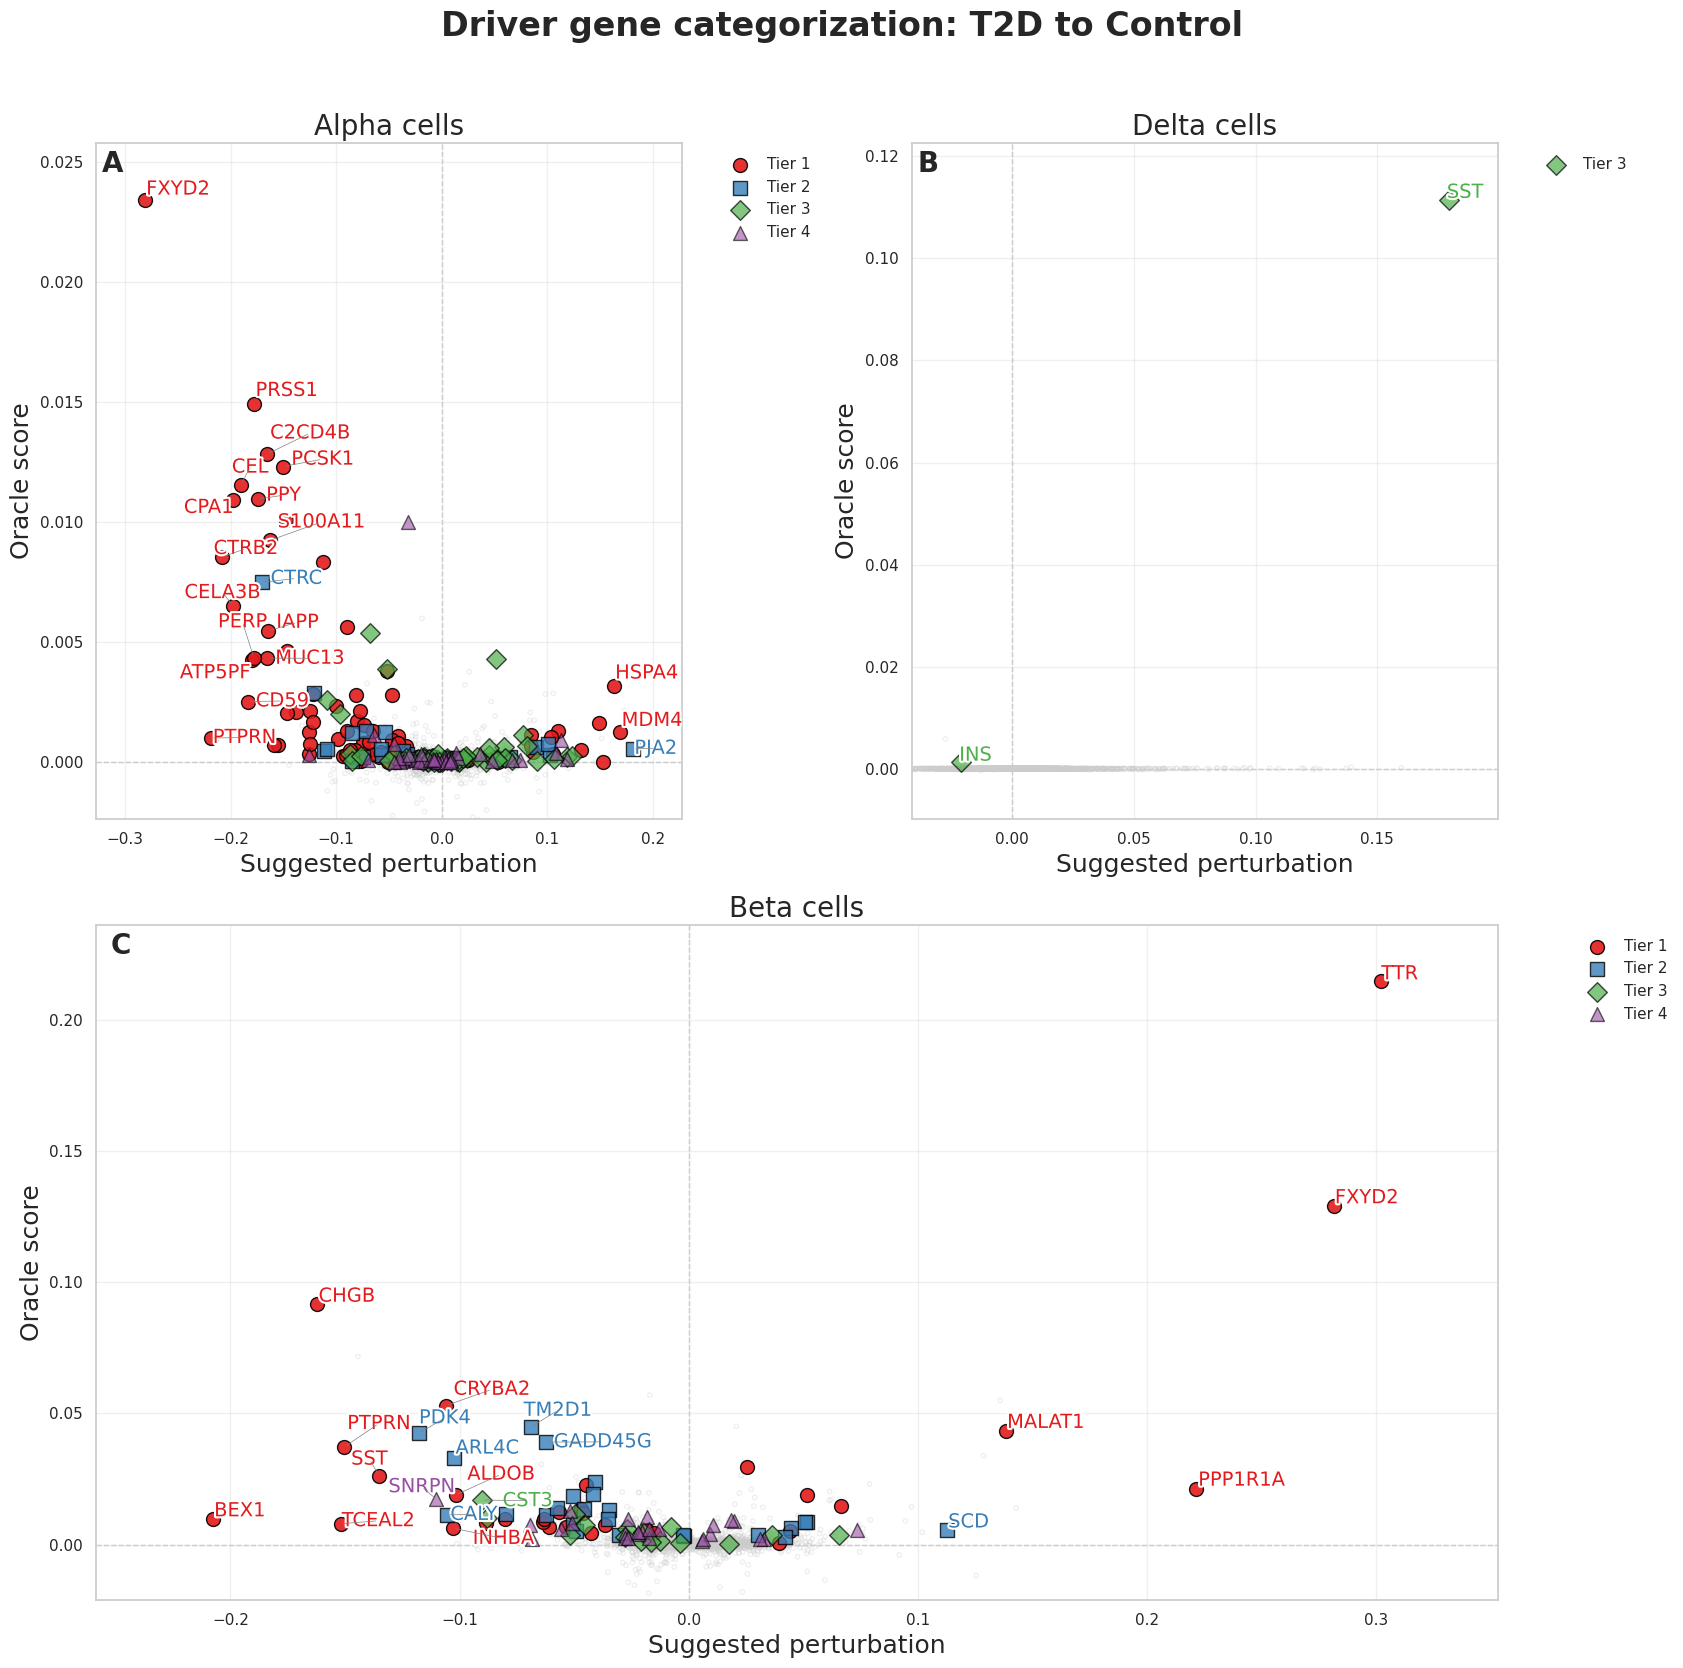

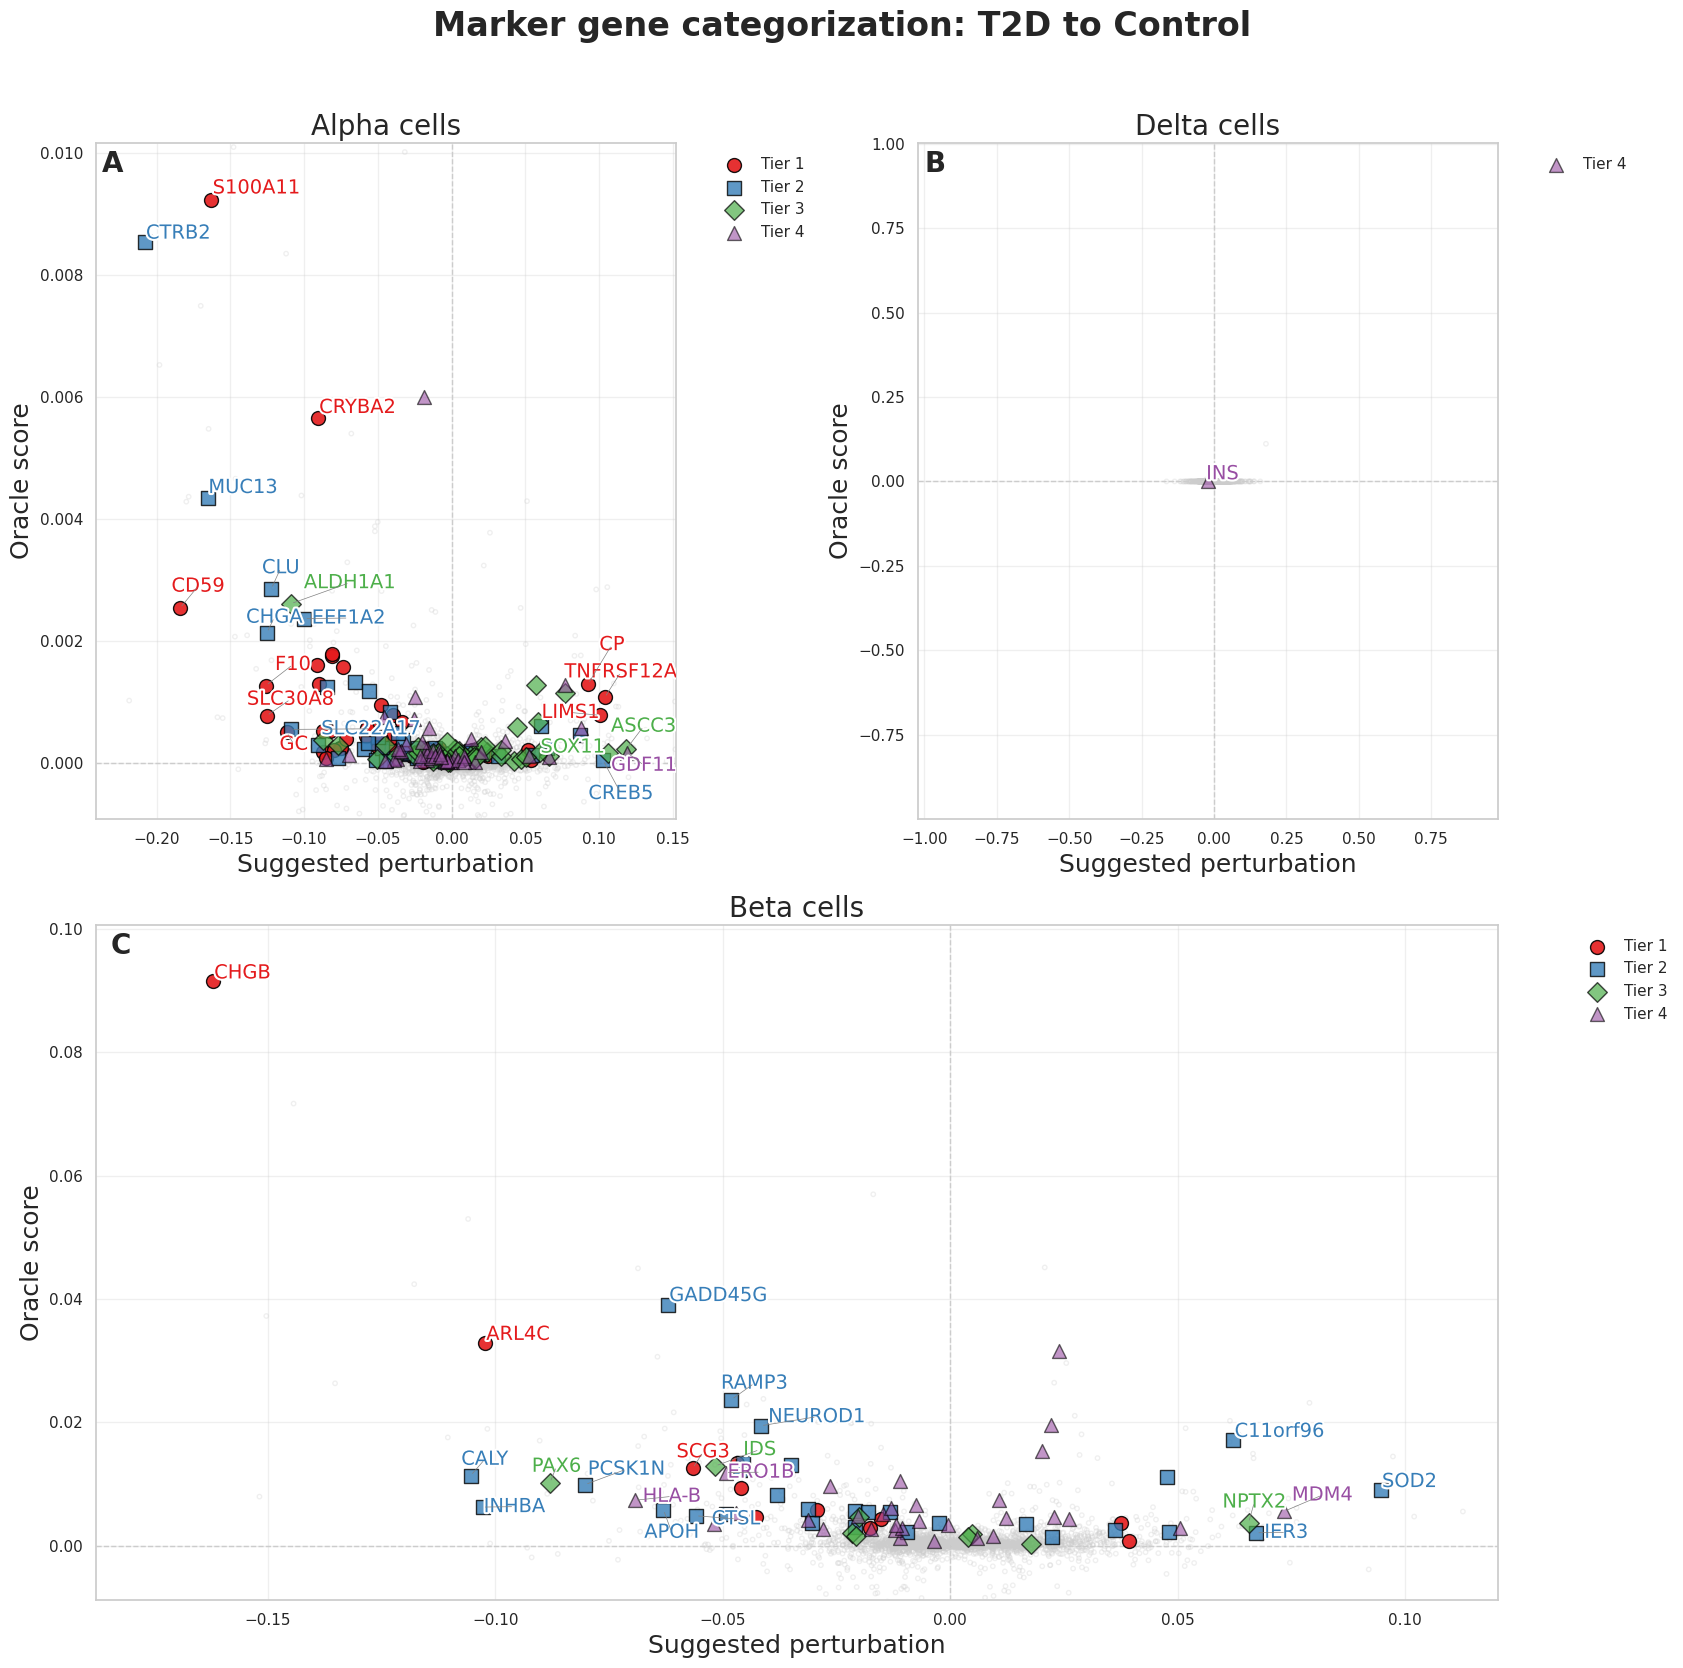

/tmp/ipykernel_34355/4033655173.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)


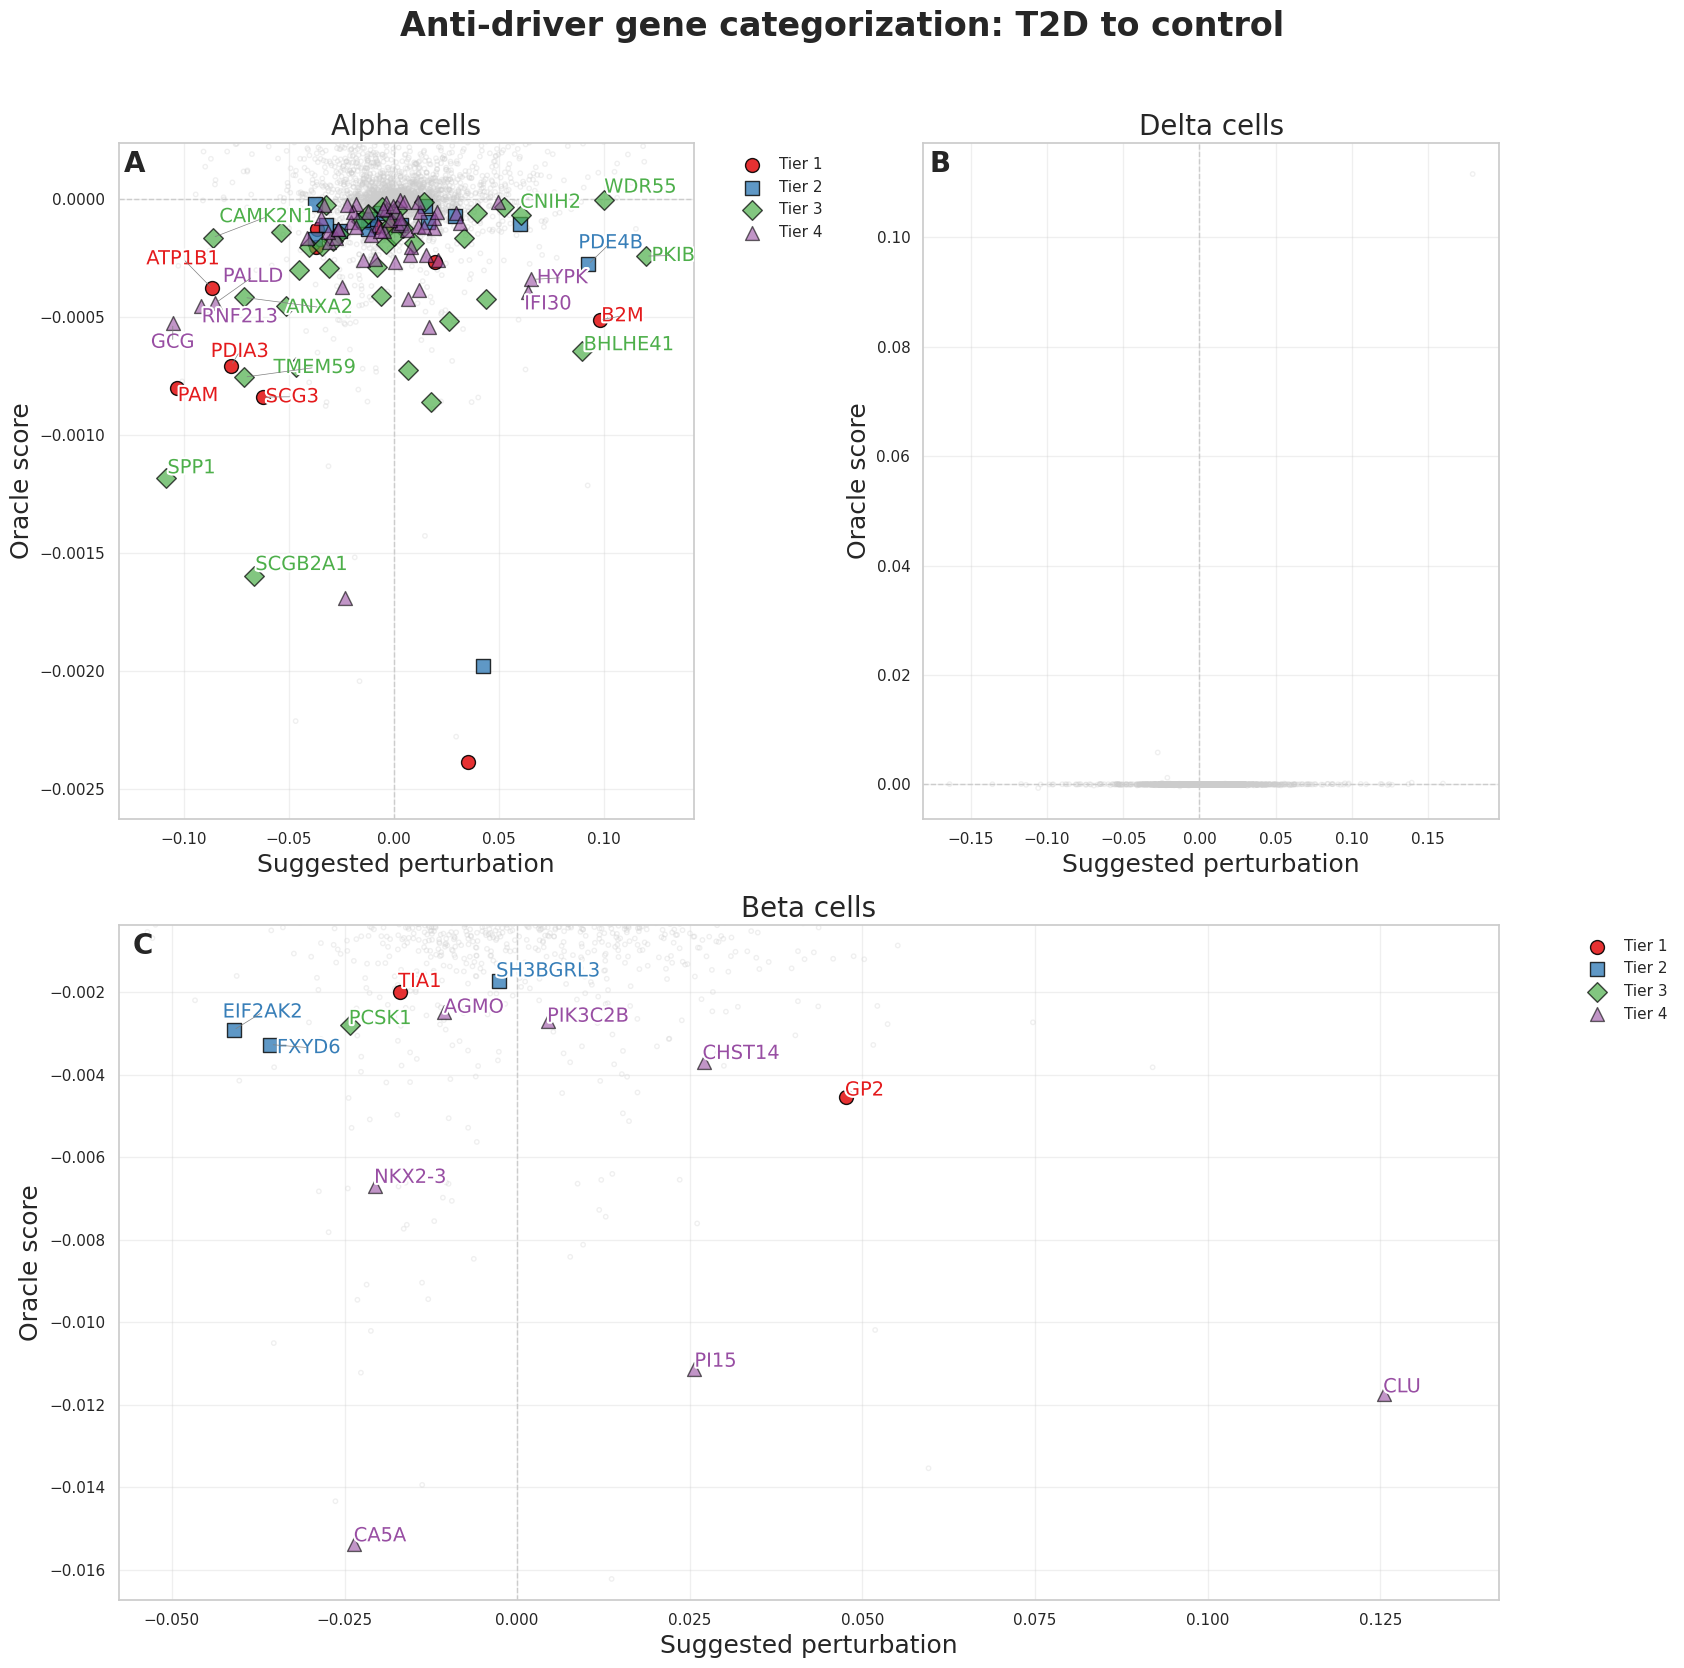

/tmp/ipykernel_34355/4033655173.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)


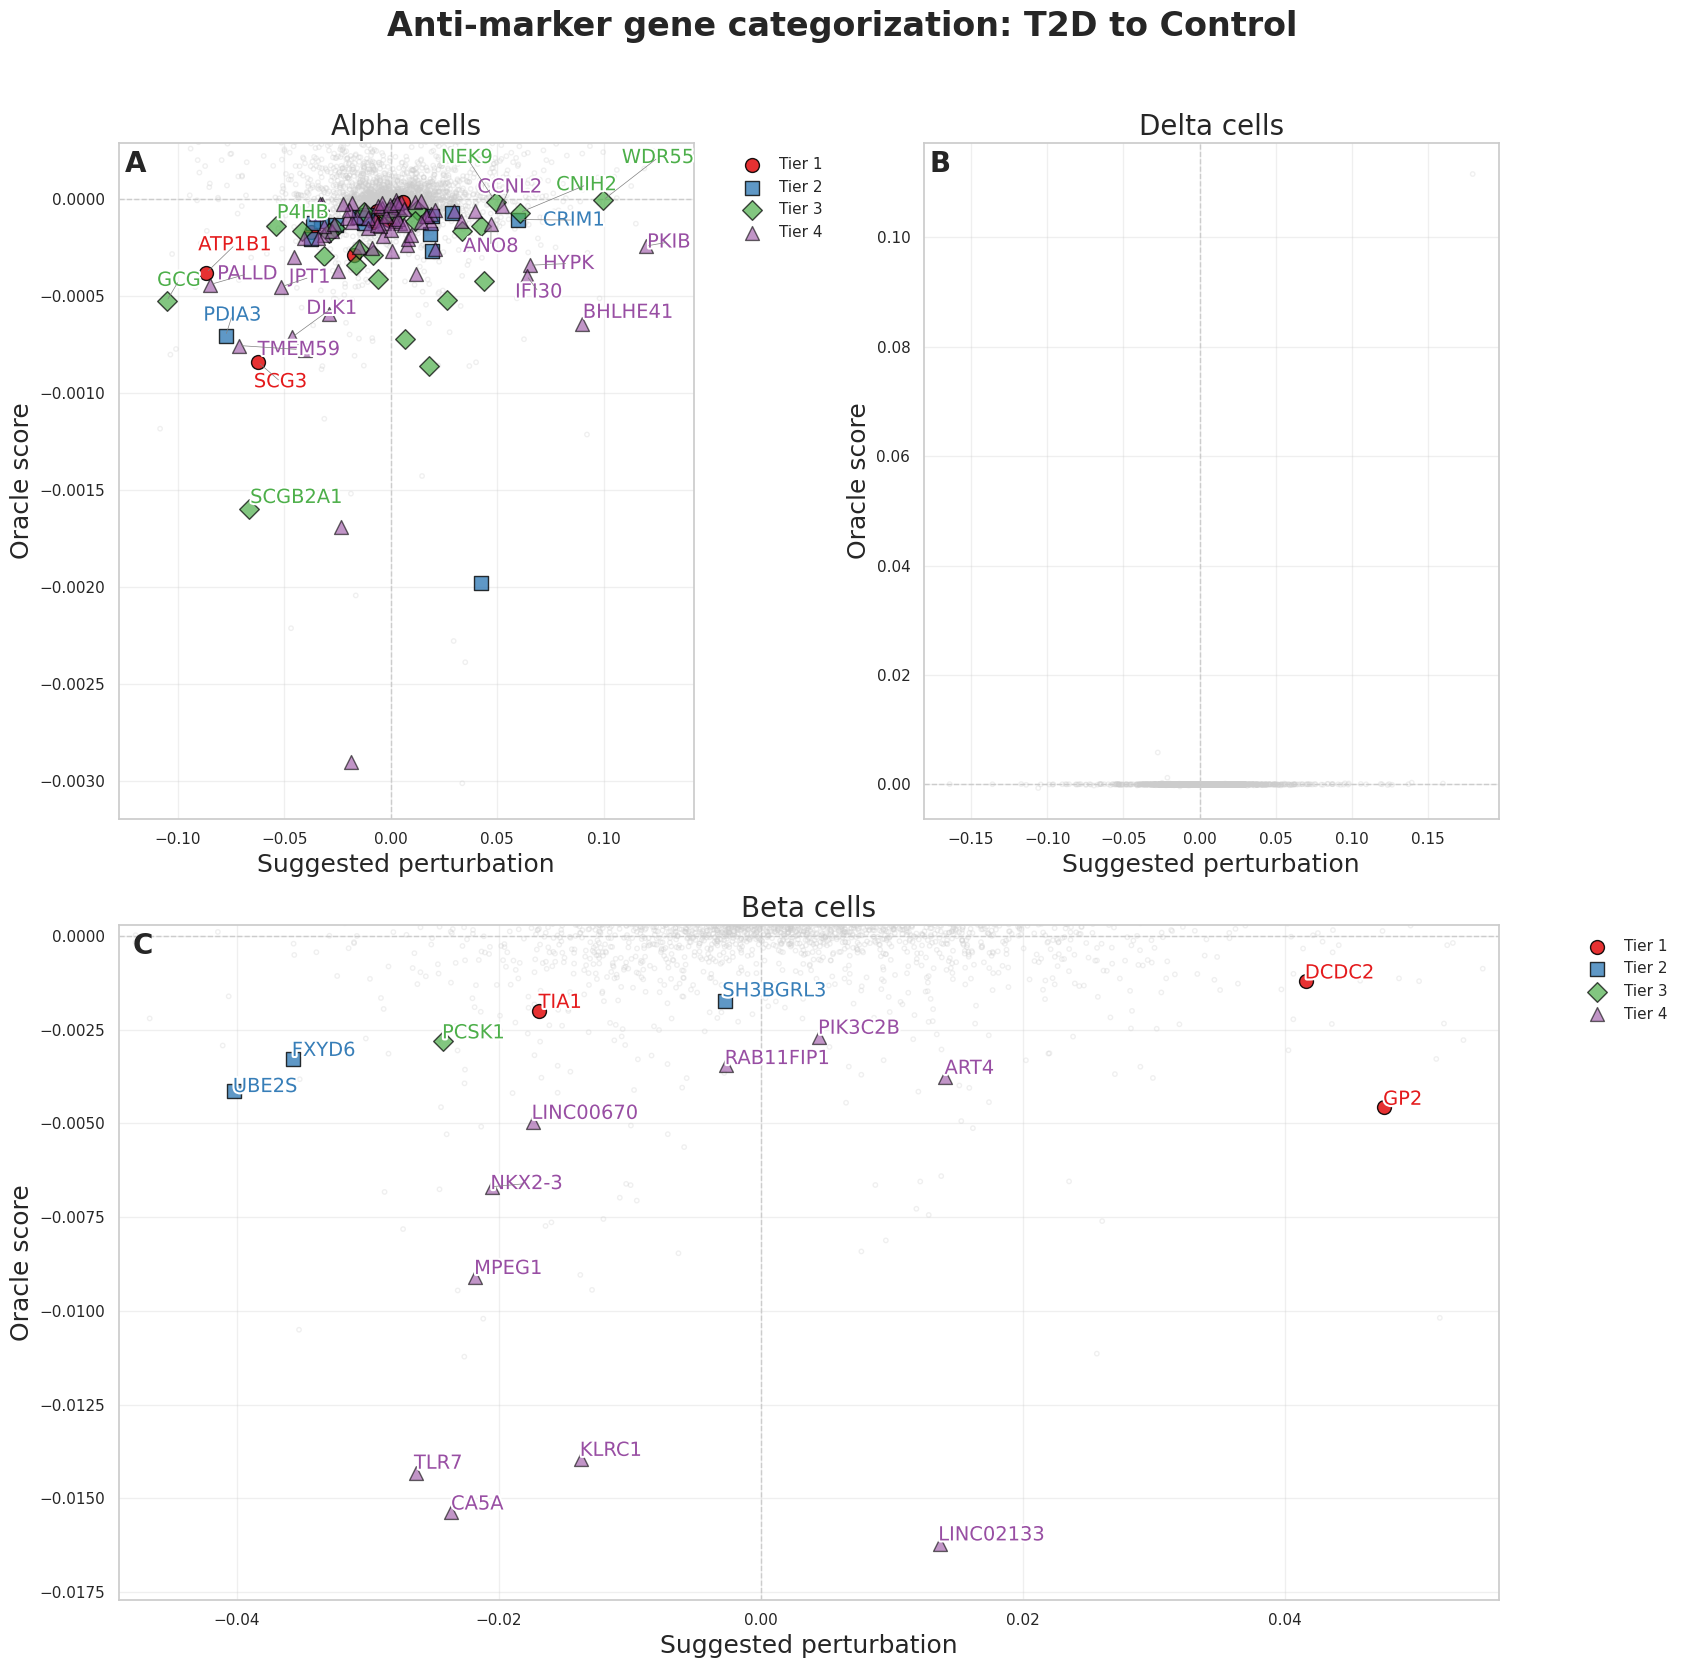

In [10]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_gene_panels(alpha, delta, beta, a2b_subtitles, priority_col, suptitle, filename):
    """
    Plots a 3-panel gene categorization grid plot for alpha, delta, and beta cells.

    Parameters:
    - alpha, delta, beta: dicts containing 'gene_categorization_results'
    - a2b_subtitles: list or tuple of 3 strings for subtitles (alpha, delta, beta)
    - priority_col: string indicating the column to prioritize for gene categorization
    - suptitle: string for the figure's main title
    - filename: string for the saved output file (should end with .png or other supported format)
    """

    # Create the grid layout
    base_width = 17
    base_height = 17 
    fig = plt.figure(figsize=(base_width, base_height))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    # Axes
    ax_alpha = fig.add_subplot(gs[0, 0])  # A
    ax_delta = fig.add_subplot(gs[0, 1])  # B
    ax_beta  = fig.add_subplot(gs[1, :])  # C

    # Plot panels
    plot_gene_categorization(
        results=alpha['gene_categorization_results'],
        a2b_subtitle=a2b_subtitles[0],
        ax=ax_alpha,
        priority_col=priority_col,
        figsize=(base_width/2, base_height/2)
    )

    plot_gene_categorization(
        results=delta['gene_categorization_results'],
        a2b_subtitle=a2b_subtitles[1],
        ax=ax_delta,
        priority_col=priority_col,
        figsize=(base_width/2, base_height/2)
    )

    plot_gene_categorization(
        results=beta['gene_categorization_results'],
        a2b_subtitle=a2b_subtitles[2],
        ax=ax_beta,
        priority_col=priority_col,
        figsize=(base_width, base_height/2)
    )

    # Add panel labels
    for label, ax in zip(['A', 'B', 'C'], [ax_alpha, ax_delta, ax_beta]):
        ax.text(
            0.01, 0.99, label,
            transform=ax.transAxes,
            ha='left', va='top',
            fontsize=20,
            fontweight='bold'
        )

    # Figure title
    fig.suptitle(suptitle, fontsize=24, fontweight='bold')
    ax_alpha.set_title('Alpha cells', fontsize=20, fontweight='normal')
    ax_beta.set_title('Beta cells', fontsize=20, fontweight='normal')
    ax_delta.set_title('Delta cells', fontsize=20, fontweight='normal')
    ax_alpha.set_ylabel('Oracle score', fontsize=18, fontweight='normal')
    ax_beta.set_ylabel('Oracle score', fontsize=18, fontweight='normal')
    ax_delta.set_ylabel('Oracle score', fontsize=18, fontweight='normal')
    ax_alpha.set_xlabel('Suggested perturbation', fontsize=18, fontweight='normal')
    ax_beta.set_xlabel('Suggested perturbation', fontsize=18, fontweight='normal')
    ax_delta.set_xlabel('Suggested perturbation', fontsize=18, fontweight='normal')
    # Layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Save figure to file
    fig.savefig(filename, dpi=300, bbox_inches='tight')

priority_col="driver_tier_forward"
suptitle="Driver gene categorization: T2D to Control"
filename=f"{main_path}results/visualizations/{priority_col}_t2d_vs_control.png"
a2b_subtitles=[
        "Alpha_cell_t2d_to_control",
        "Delta_cell_t2d_to_control",
        "Beta_cell_t2d_to_control"
    ]
plot_gene_panels(
    alpha=alpha,
    delta=delta,
    beta=beta,
    a2b_subtitles=a2b_subtitles,
    priority_col=priority_col,
    suptitle=suptitle,
    filename=filename
)


priority_col="marker_tier_forward"
suptitle="Marker gene categorization: T2D to Control"
filename=f"{main_path}results/visualizations/{priority_col}_t2d_vs_control.png"
a2b_subtitles=[
        "Alpha_cell_t2d_to_control",
        "Delta_cell_t2d_to_control",
        "Beta_cell_t2d_to_control"
    ]
plot_gene_panels(
    alpha=alpha,
    delta=delta,
    beta=beta,
    a2b_subtitles=a2b_subtitles,
    priority_col=priority_col,
    suptitle=suptitle,
    filename=filename
)



priority_col="driver_tier_anti"
suptitle="Anti-driver gene categorization: T2D to control"
filename=f"{main_path}results/visualizations/{priority_col}_t2d_vs_control.png"
a2b_subtitles=[
        "Alpha_cell_t2d_to_control",
        "Delta_cell_t2d_to_control",
        "Beta_cell_t2d_to_control"
    ]
plot_gene_panels(
    alpha=alpha,
    delta=delta,
    beta=beta,
    a2b_subtitles=a2b_subtitles,
    priority_col=priority_col,
    suptitle=suptitle,
    filename=filename
)


priority_col="marker_tier_anti"
suptitle="Anti-marker gene categorization: T2D to Control"
filename=f"{main_path}results/visualizations/{priority_col}_t2d_vs_control.png"
a2b_subtitles=[
        "Alpha_cell_t2d_to_control",
        "Delta_cell_t2d_to_control",
        "Beta_cell_t2d_to_control"
    ]
plot_gene_panels(
    alpha=alpha,
    delta=delta,
    beta=beta,
    a2b_subtitles=a2b_subtitles,
    priority_col=priority_col,
    suptitle=suptitle,
    filename=filename
)

In [11]:


import os
import shutil
import glob
import subprocess
from datetime import datetime

def copy_xlsx_files(main_path, result_paths, final_output_path, readme_text):
    """
    Copies all .xlsx files from specified result folders into a final output directory,
    along with any .png files (into a subfolder called 'visualizations'). Then creates a zip file.

    Parameters:
    - main_path (str): Base directory containing result folders.
    - result_paths (list): List of subdirectories to search for files.
    - final_output_path (str): Directory where copied files will be stored.
    - readme_text (str): Text content for the README file in the final output directory.
    """
    # Ensure the final output directory exists
    os.makedirs(final_output_path, exist_ok=True)

    # Path for visualizations subfolder
    vis_path = os.path.join(final_output_path, "visualizations")
    os.makedirs(vis_path, exist_ok=True)

    for folder in result_paths:
        folder_path = os.path.join(main_path, folder)

        if os.path.isdir(folder_path):
            # Copy .xlsx files
            xlsx_files = glob.glob(os.path.join(folder_path, "*.xlsx"))
            for file in xlsx_files:
                shutil.copy(file, final_output_path)

            # Copy .png files to 'visualizations'
            png_files = glob.glob(os.path.join(folder_path, "*.png"))
            for file in png_files:
                shutil.copy(file, vis_path)

    # Create README
    readme_path = os.path.join(final_output_path, "README.txt")
    with open(readme_path, "w") as readme_file:
        readme_file.write(readme_text)

    print(f"✅ .xlsx and .png files copied. README created in: {final_output_path}")

    # Create ZIP
    date_prefix = datetime.now().strftime("%y%m%d")
    zip_filename = f"{date_prefix}_gosip_results_freeze.zip"
    zip_path = os.path.join(main_path, zip_filename)

    subprocess.run(
        f'cd "{final_output_path}" && zip -r "{zip_path}" .',
        shell=True,
        executable="/bin/bash"
    )

    print(f"✅ Results folder zipped successfully: {zip_path}")

readme_text = f"""
## README - Analysis Pipeline Output
This directory contains the results generated from the **complete_analysis_pipeline** function.
The outputs are saved in an **Excel file** (`*_analysis_results.xlsx`) with multiple sheets summarizing each analysis.

## Visualizations
- Scatterplot of gene categorization results by driver-forward tiers.
- Data distribution plots for HPAP and developmental datasets.
- Simulation result plots.

### Excel File: *_analysis_results.xlsx
The file includes the following sheets:
---
### 1. {{start}}_to_{{goal}}
- **Forward transition:** {{start}} -> {{goal}}, sorted by `oracle_score`.
- **Columns:**
  - `label` – Gene label.
  - `oracle_score` – Oracle score in [−1, 1].
  - `pval_acat_fdr` – BH-adjusted combined p-value.
  - `suggested_perturbation` – Δ({{goal}} − {{start}}).
  - `out_degree_pagerank_positive` – Out‐degree PageRank centrality.
  - `in_degree_pagerank_positive` – In‐degree PageRank centrality.
  - (All other original result columns.)

### 2. {{goal}}_to_{{start}}
- **Reverse transition:** {{goal}} -> {{start}}, sorted by `oracle_score`.
- **Columns:** Same as the **1.** sheet.

### 3. activating_drugs
- Potential activating compounds mapped to forward-significant genes.
- Merged DrugBank (v5.1.13) with forward results.
- **Columns:**
  - `drugbank_id`
  - `drug_name`
  - `drug_description`
  - `effect_label` – Original activation/inhibition label.
  - `cellular_location_of_action`
  - `chromosomal_location_of_target`
  - `target_id`
  - `target_name`
  - `organism_tested`
  - `label` – Gene label.
  - `oracle_score`
  - `pval_acat_fdr`
  - `suggested_perturbation`
  - `out_degree_pagerank_positive`

### 4. inhibitory_drugs
- Potential inhibitory compounds similarly mapped.
- **Columns:** Same as **3.**

### 5. gene_categorization_results
- Integrated classification across both directions.
- **Columns:**
  - `oracle_score_{{start}}_to_{{goal}}`
  - `oracle_score_{{goal}}_to_{{start}}`
  - `pval_acat_fdr_{{start}}_to_{{goal}}`
  - `pval_acat_fdr_{{goal}}_to_{{start}}`
  - `pert_{{start}}_to_{{goal}}`
  - `pert_{{goal}}_to_{{start}}`
  - `out_pr_{{start}}_to_{{goal}}`
  - `out_pr_{{goal}}_to_{{start}}`
  - `in_pr_{{start}}_to_{{goal}}`
  - `in_pr_{{goal}}_to_{{start}}`
  - `p_value_category`
  - `regulator_category`
  - `driver_category`
  - `marker_category`
  - `driver_tier_forward`
  - `driver_tier_anti`
  - `marker_tier_forward`
  - `marker_tier_anti`

### 6. p_value_description
- Definitions for each `p_value_category`.

### 7. regulator_description
- Definitions for each `regulator_category`.

### 8. driver_forward_description
- Tier definitions for `driver_tier_forward`.

### 9. driver_anti_description
- Tier definitions for `driver_tier_anti`.

### 10. marker_forward_description
- Tier definitions for `marker_tier_forward`.

### 11. marker_anti_description
- Tier definitions for `marker_tier_anti`.

---

## Additional Information
- Inputs: Two CSVs (forward and reverse transitions) and a DrugBank CSV.
- Classification logic applies p-value thresholds, perturbation directionality, and PageRank quantiles.
- Description tables are included for transparency and reproducibility.
"""





import glob
import os
import shutil

def copy_png_files(src_dir: str, dst_dir: str,target='*.png') -> None:
    """
    Copy all .png files from src_dir to dst_dir (non-recursively), preserving metadata.
    
    :param src_dir: Path to the source directory
    :param dst_dir: Path to the destination directory
    """
    # Ensure the destination directory exists
    os.makedirs(dst_dir, exist_ok=True)

    # Build the glob pattern for .png files
    pattern = os.path.join(src_dir, target)

    # Copy each .png file
    for src_path in glob.glob(pattern):
        filename = os.path.basename(src_path)
        dst_path = os.path.join(dst_dir, filename)
        shutil.copy2(src_path, dst_path)
        print(f"Copied {src_path} → {dst_path}")

        
#result_paths=['hpap_and_developmental','hpap_only','Cardiomyopathy','cad','adenocarcinoma_pancreas','breast_cancer','colorectal_cancer','multiple_myeloma']
result_paths=['hpapnb3k']#,'Cardiomyopathy','cad','adenocarcinoma_pancreas']
final_output_path = main_path+"results/"


formatted_readme = readme_text.format(
    start="Start",
    goal="Goal"
)
# Ensure the final output directory exists
os.makedirs(final_output_path, exist_ok=True)

# Path for visualizations subfolder
vis_path = os.path.join(final_output_path, "visualizations")
os.makedirs(vis_path, exist_ok=True)
json_path = os.path.join(final_output_path, "jsons")
os.makedirs(json_path, exist_ok=True)
import shutil

main_path
zero_main_path='/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/'
copy_png_files(zero_main_path, vis_path)
copy_png_files(main_path, vis_path)
copy_png_files(f'{main_path}hpapnb3k/', vis_path)
copy_png_files(f'{main_path}hpapnb3k/', json_path,target='*.json')
copy_xlsx_files(main_path, result_paths, final_output_path, formatted_readme)



Copied /home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/simple_gfn_simulation.png → /home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/results/visualizations/simple_gfn_simulation.png
Copied /home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/gflownet_example.png → /home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/results/visualizations/gflownet_example.png
Copied /home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/SimulationResults.png → /home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/results/visualizations/SimulationResults.png
Copied /home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/SimulationResults_acat_fdr_filtered.png → /home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/results/visualizations/SimulationResults_acat_fdr_filtered.png
Copied /home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/SimulationResults_median_pval_filtered